<a href="https://colab.research.google.com/github/limshaocong/analyticsEdge/blob/main/FAANG_Volume_Prediction_caa%201Dec21.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Preliminaries**

In [1]:
suppressMessages(library(tidyverse)) # generic must have package
suppressMessages(library(dplyr))
suppressMessages(library(ggplot2)) # plotting package
suppressMessages(library(lubridate)) # easy comprehension of dates from string to correct datetime format
suppressMessages(library(data.table))
suppressMessages(library(purrr)) # reduce
if("patchwork" %in% rownames(installed.packages()) == FALSE) {install.packages("patchwork")}
suppressMessages(library(patchwork))
if("caret" %in% rownames(installed.packages()) == FALSE) {install.packages("caret")}
suppressMessages(library(caret))

Warning message in system("timedatectl", intern = TRUE):
“running command 'timedatectl' had status 1”
Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependencies ‘listenv’, ‘parallelly’, ‘future’, ‘globals’, ‘future.apply’, ‘progressr’, ‘numDeriv’, ‘SQUAREM’, ‘lava’, ‘prodlim’, ‘proxy’, ‘iterators’, ‘gower’, ‘ipred’, ‘timeDate’, ‘e1071’, ‘foreach’, ‘ModelMetrics’, ‘plyr’, ‘pROC’, ‘recipes’, ‘reshape2’




In [2]:
options(repr.plot.width = 10,
        repr.plot.height = 9,
        repr.plot.pointsize = 20)

Import data and check for any NA within the file

In [3]:
path = "https://raw.githubusercontent.com/limshaocong/analyticsEdge/main/Datasets/FAANG/altdata.csv"
df = read.csv(path) %>% mutate(date = ymd(date)) %>% select(- open, - close, - high, - low)

if (dim(df)[1] == dim(na.omit(df))[1]) {
  print("No missing data.")
} else {
  print("Missing data")
}

[1] "No missing data."


# **Exploratory Analysis**

Overview of Data

In [16]:
head(df, 5)

,date,ticker,vol,newssentiment,newsmentions,twtrmentions,twtrsentiment,wsbsentiment,wsbmentions,retailvol,⋯,twtrmentions5MA,wsbmentions5MA,newsmentions5MA,twtrmentions10MA,wsbmentions10MA,newsmentions10MA,retailvollag1,retailvollag2,retailvollag4,target
,<date>,<chr>,<int>,<dbl>,<int>,<int>,<dbl>,<dbl>,<int>,<int>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<dbl>,<dbl>,<int>
1,2019-01-08,FB,26252863,63.0,2,569,0.26889279,0.3528667,1,11163579,⋯,473.6,1,0.8,487.8,1,0.6,11163579,10410940,8964350,9658300
2,2019-01-09,FB,22203279,50.0,0,489,0.09406953,-0.3818000,1,9658300,⋯,461.0,1,0.8,473.5,1,0.4,9658300,8218650,8249882,6779001
3,2019-01-10,FB,16111304,50.5,2,464,0.17456897,0.3246000,1,6779001,⋯,457.8,1,0.8,469.0,1,0.5,6779001,6088824,7751706,5398647
4,2019-01-11,FB,12907031,50.0,0,368,0.17663043,-0.0799400,1,5398647,⋯,467.2,1,0.4,487.2,1,0.6,5398647,7284762,7707233,9170878
5,2019-01-14,FB,20515678,50.0,0,399,0.23809524,-0.1558800,1,9170878,⋯,462.0,1,0.4,495.3,1,0.6,9170878,9325642,7777200,9480406


In [17]:
str(df)

'data.frame':	3310 obs. of  40 variables:
 $ date             : Date, format: "2019-01-08" "2019-01-09" ...
 $ ticker           : chr  "FB" "FB" "FB" "FB" ...
 $ vol              : int  26252863 22203279 16111304 12907031 20515678 24065513 18060414 15787914 32309412 22393694 ...
 $ newssentiment    : num  63 50 50.5 50 50 50 50 37 40 50 ...
 $ newsmentions     : int  2 0 2 0 0 0 0 1 1 0 ...
 $ twtrmentions     : int  569 489 464 368 399 616 463 476 613 496 ...
 $ twtrsentiment    : num  0.2689 0.0941 0.1746 0.1766 0.2381 ...
 $ wsbsentiment     : num  0.3529 -0.3818 0.3246 -0.0799 -0.1559 ...
 $ wsbmentions      : int  1 1 1 1 1 1 1 1 1 1 ...
 $ retailvol        : int  11163579 9658300 6779001 5398647 9170878 9480406 7058870 5805217 11946377 8903335 ...
 $ instvol          : int  15100214 12547579 9346003 7509384 11349400 14588416 10966844 9982697 19083235 13475359 ...
 $ retailperc       : num  0.425 0.435 0.42 0.418 0.447 ...
 $ newssentimentlag1: num  50 63 50 50.5 50 50 50 50 37 40

662 trading days worth of training data from Jan 8, 2019 to Aug 30, 2021.

In [18]:
df %>%
  group_by(ticker) %>%
  summarise(n())

ticker,n()
<chr>,<int>
AAPL,662
AMZN,662
FB,662
GOOGL,662
NFLX,662


# **Data Preparation**

Train-test split

In [19]:
split = as.Date("2020-11-24")

# Train-test split
train = df %>% filter(date < split)
test = df %>% filter(date >= split)

train_days = dim(train)[1]/5
test_days = dim(test)[1]/5

train_prop = train_days / (train_days + test_days)

paste0("Training data proportion: ", round(train_prop * 100, 1), "%. Total training days = ", train_days)

[1] "Training data proportion: 71.8%. Total training days = 475"

Train-validate Split - as normal k-fold CV does not work on time series, an expanding window approach is used (see Section 4.3 of https://topepo.github.io/caret/data-splitting.html#time). With these parameters, CV-error will be run on 5 different validation sets.

In [20]:
index = 1:train_days
slices = createTimeSlices(index, initialWindow = 230, horizon = 100, fixedWindow = FALSE, skip = 28)

trainslices = slices[[1]] # specific slices callable by df[trainslices[[i]],]
testslices = slices[[2]]

lapply(slices, length)

$train
[1] 6

$test
[1] 6

In [21]:
for (fold in 1:6) {
  trainN = length(slices$train[[fold]])
  testN = length(slices$test[[fold]])
  trainperc = round(trainN / (trainN + testN), 2) * 100

  print(paste0("Fold ", fold, ": ", trainN, " train data. 100 test data. ", trainperc, "%"))
}

[1] "Fold 1: 230 train data. 100 test data. 70%"
[1] "Fold 2: 259 train data. 100 test data. 72%"
[1] "Fold 3: 288 train data. 100 test data. 74%"
[1] "Fold 4: 317 train data. 100 test data. 76%"
[1] "Fold 5: 346 train data. 100 test data. 78%"
[1] "Fold 6: 375 train data. 100 test data. 79%"


In [22]:
#slices$train
#slices$test

# **Model Building**

In [23]:
if("Metrics" %in% rownames(installed.packages()) == FALSE) {install.packages("Metrics")}
suppressMessages(library(Metrics))
if("randomForest" %in% rownames(installed.packages()) == FALSE) {install.packages("randomForest")}
suppressMessages(library(randomForest))
if("xgboost" %in% rownames(installed.packages()) == FALSE) {install.packages("xgboost")}
library(xgboost)
if("zoo" %in% rownames(installed.packages()) == FALSE) {install.packages("zoo")}
library(zoo) # rolling mean

## **Naive Model**

To assess what is the best naive model to provide a baseline prediction, create a function to test what type of MA performs best.

In [24]:
# Naive model using MA

run_naive = function(x, MAdays) {

  # Create target variable based on given MA days
  naive = df %>%
    filter(ticker == x) %>%
    mutate(volMA = rollmean(vol, align = "right", k = MAdays, fill = NA)) %>%
    select(date, ticker, target, volMA)

  # Store the errors for each of the 7 folds
  cvrmse = list()
  cvmae = list()

  for (i in 1:6) {
    
    validate = naive[testslices[[i]],]
    cvrmse[i] = rmse(validate$target, validate$volMA)
    cvmae[i] = mae(validate$target, validate$volMA)

  }

  # Compute aggregated statistics
  output = list()
  output[["ticker"]] = x
  output[["RMSE"]] = mean(unlist(cvrmse))
  output[["RMSESD"]] = sd(unlist(cvrmse))
  output[["MAE"]] = mean(unlist(cvmae))
  output[["MAESD"]] = sd(unlist(cvmae))

  output = output

}

The results indicate that using the maximum possible MA of 230 days provides the lowest error.

In [25]:
tickers = list("FB", "AAPL", "AMZN", "NFLX", "GOOGL")

for (x in tickers) {

  n1 = run_naive(x, 1)
  n50 = run_naive(x, 50)
  n150 = run_naive(x, 150)
  n200 = run_naive(x, 200)
  n230 = run_naive(x, 230)

  ntotal = rbind(n1, n50, n150, n200, n230) 

  print(ntotal)

}

     ticker RMSE     RMSESD  MAE      MAESD  
n1   "FB"   15973783 1103528 13552685 1053109
n50  "FB"   13509548 2119832 12840121 2164882
n150 "FB"   10747364 2901855 10076131 2911848
n200 "FB"   9765942  2166245 9118983  2168498
n230 "FB"   9413647  1697247 8769982  1704406
     ticker RMSE      RMSESD   MAE      MAESD   
n1   "AAPL" 101912633 12208016 87608934 9790274 
n50  "AAPL" 95248407  11791089 86847804 11671075
n150 "AAPL" 78262677  16119361 72656136 17054052
n200 "AAPL" 70461889  14096086 65074991 14511175
n230 "AAPL" 66400556  12267754 61186562 12501870
     ticker RMSE    RMSESD   MAE     MAESD   
n1   "AMZN" 3424935 309839   3021463 195775  
n50  "AMZN" 3071119 356491.2 2878729 346459.6
n150 "AMZN" 2585648 564070.1 2447764 610300.2
n200 "AMZN" 2356100 415677   2216469 457885  
n230 "AMZN" 2268850 306187   2129738 345349  
     ticker RMSE    RMSESD   MAE     MAESD   
n1   "NFLX" 5294691 342643.4 4406934 447902.8
n50  "NFLX" 4827286 403049.5 4576051 380820.1
n150 "NFLX" 4761

Generate the results for all naive predictions based on a 230MA

In [28]:
nfb = run_naive("FB", 230)
naapl = run_naive("AAPL", 230)
namzn = run_naive("AMZN", 230)
nnflx = run_naive("NFLX", 230)
ngoogl = run_naive("GOOGL", 230)

n230 = rbind(nfb, naapl, namzn, nnflx, ngoogl) %>% as.data.frame() %>% mutate(model = "Naive-MA")

n230

,ticker,RMSE,RMSESD,MAE,MAESD,model
,<named list>,<named list>,<named list>,<named list>,<named list>,<chr>
nfb,FB,9413647,1697247,8769982,1704406,Naive-MA
naapl,AAPL,66400556,12267754,61186562,12501870,Naive-MA
namzn,AMZN,2268850,306187,2129738,345349,Naive-MA
nnflx,NFLX,4696793,325684.7,4488460,363920.6,Naive-MA
ngoogl,GOOGL,1180863,226063.7,1139687,244152,Naive-MA


In [29]:
n230 %>% write.csv("naive.csv")

ERROR: ignored

## **Defining functions to run CART, Random Forest and XGBoost**

Pre-defining the training control (expanding window), hyperparameter search grid for all models

In [30]:
# Function to construct CART tree
cart = function(trainX, trainY) {
  
  train_control = trainControl(method = "timeslice",
                            initialWindow = 130,
                            horizon = 30,
                            fixedWindow = FALSE,
                            skip = 40,
                            savePredictions = TRUE)

  # hyperparameters
  cp_values = data.frame(.cp = seq(0, 0.02, by = 0.0001))

  model = train(x = trainX,
                y = trainY,
                method = "rpart",
                trControl = train_control,
                tuneGrid = cp_values)

}

# Function to construct RandomForest
randomforest = function(trainX, trainY) {

  train_control = trainControl(method = "timeslice",
                                initialWindow = 130,
                                horizon = 30,
                                fixedWindow = FALSE,
                                skip = 40,
                                savePredictions = TRUE)

  # hyperparameters
  n_pred = dim(trainX)[2]
  mtry_low = round(0.4 * n_pred)
  mtry_upp = round(0.6 * n_pred)
  mtry_grid = data.frame(mtry = seq(mtry_low, mtry_upp, by = 1))
      
  model = train(x = trainX,
                y = trainY,
                method = "rf",
                trControl = train_control,
                tuneGrid = mtry_grid,
                ntree = 300,
                nodesize = 5)

}

# Function to construct XGBoost
xgb = function(trainX, trainY, testX, testY) {

  train_control = trainControl(method = "timeslice",
                              initialWindow = 130,
                              horizon = 30,
                              fixedWindow = FALSE,
                              skip = 40,
                              savePredictions = TRUE,
                              allowParallel = TRUE)

  # hyperparameters that require further tuning
  parm_grid = expand.grid(nrounds = 100, 
                          max_depth = 2:4, 
                          eta = seq(0.01, 0.05, by = 0.005),
                          gamma = c(0, 0.05),
                          colsample_bytree = 1,
                          min_child_weight = 1,
                          subsample = c(0.3, 0.5))

  model = train(x = trainX,
                y = trainY,
                method = "xgbTree",
                tuneGrid = parm_grid,
                trControl = train_control)

}

# Function to plot 
plotlastfold = function(model) {
  
  train_pred = predict(model$finalModel, newdata = trainX)
  
  model_df = data.frame(timesteps = seq(1, train_days), predicted = train_pred, actual = trainY)

  ggplot(data = model_df, (aes(x = timesteps))) +
    geom_line(aes(y = predicted), color = "blue") +
    geom_line(aes(y = actual), color = "black")

}


Defining 2 possible feature sets. 

1.   Reduced feature set - only using t-1 data points
2.   Full feature set - expanded with MA and lag features

Reduced feature set only accounts for sentiment effects in the preceding trading day.

Full feature uses lag and moving average indicators, in addition to the reduced feature set, so as to use sentiment in recent history to predict volume



In [31]:
# $ date             : Date, format: "2019-01-08" "2019-01-09" ...
# $ ticker           : chr  "FB" "FB" "FB" "FB" ...
# $ vol              : int  26252863 22203279 16111304 12907031 20515678 24065513 18060414 15787914 32309412 22393694 ...
# $ newssentiment    : num  63 50 50.5 50 50 50 50 37 40 50 ...
# $ newsmentions     : int  2 0 2 0 0 0 0 1 1 0 ...
# $ twtrmentions     : int  569 489 464 368 399 616 463 476 613 496 ...
# $ twtrsentiment    : num  0.2689 0.0941 0.1746 0.1766 0.2381 ...
# $ wsbsentiment     : num  0.3529 -0.3818 0.3246 -0.0799 -0.1559 ...
# $ wsbmentions      : int  1 1 1 1 1 1 1 1 1 1 ...
# $ retailvol        : int  11163579 9658300 6779001 5398647 9170878 9480406 7058870 5805217 11946377 8903335 ...
# $ instvol          : int  15100214 12547579 9346003 7509384 11349400 14588416 10966844 9982697 19083235 13475359 ...
# $ retailperc       : num  0.425 0.435 0.42 0.418 0.447 ...
# $ newssentimentlag1: num  50 63 50 50.5 50 50 50 50 37 40 ...
# $ newsmentionslag1 : int  0 2 0 2 0 0 0 0 1 1 ...
# $ twtrmentionslag1 : int  415 569 489 464 368 399 616 463 476 613 ...
# $ twtrsentimentlag1: num  0.2024 0.2689 0.0941 0.1746 0.1766 ...
# $ wsbsentimentlag1 : num  -0.2222 0.3529 -0.3818 0.3246 -0.0799 ...
# $ wsbmentionslag1  : int  1 1 1 1 1 1 1 1 1 1 ...
# $ newssentimentlag2: num  50 50 63 50 50.5 50 50 50 50 37 ...
# $ newsmentionslag2 : int  0 0 2 0 2 0 0 0 0 1 ...
# $ twtrmentionslag2 : int  431 415 569 489 464 368 399 616 463 476 ...
# $ twtrsentimentlag2: num  0.058 0.2024 0.2689 0.0941 0.1746 ...
# $ wsbsentimentlag2 : num  -0.0623 -0.2222 0.3529 -0.3818 0.3246 ...
# $ wsbmentionslag2  : int  1 1 1 1 1 1 1 1 1 1 ...
# $ newssentimentlag4: num  50 50 50 50 63 50 50.5 50 50 50 ...
# $ newsmentionslag4 : int  2 0 0 0 2 0 2 0 0 0 ...
# $ twtrmentionslag4 : int  606 521 431 415 569 489 464 368 399 616 ...
# $ twtrsentimentlag4: num  0.1172 0.0307 0.058 0.2024 0.2689 ...
# $ wsbsentimentlag4 : num  0.1815 -0.1377 -0.0623 -0.2222 0.3529 ...
# $ wsbmentionslag4  : int  1 1 1 1 1 1 1 1 1 1 ...
# $ twtrmentions5MA  : num  474 461 458 467 462 ...
# $ wsbmentions5MA   : num  1 1 1 1 1 1 1 1 1 1 ...
# $ newsmentions5MA  : num  0.8 0.8 0.8 0.4 0.4 0.2 0.4 0.4 0.6 1.2 ...
# $ twtrmentions10MA : num  488 474 469 487 495 ...
# $ wsbmentions10MA  : num  1 1 1 1 1 1 1 1 1 1 ...
# $ newsmentions10MA : num  0.6 0.4 0.5 0.6 0.6 0.5 0.8 0.6 0.8 1.1 ...
# $ retailvollag1    : int  11163579 9658300 6779001 5398647 9170878 9480406 7058870 5805217 11946377 8903335 ...
# $ retailvollag2    : num  10410940 8218650 6088824 7284762 9325642 ...
# $ retailvollag4    : num  8964350 8249882 7751706 7707233 7777200 ...
# $ target           : int  9658300 6779001 5398647 9170878 9480406 7058870 5805217 11946377 8903335 7344744 ...

# Reduced feature set consists of
# Sentiment - news, twitter, wsb
# Mentions - news, twitter, wsb
# Vol - total volume, retail volume, institutional volume
# Retail volume as % of total volume
reduced_feature = c(3:12)

# Full feature includes the entirety of reduced feature set, as well as lag and MA features
# Both are intended to determine if sentiment effects can affect volume beyond the next trading day
# Sentiment - lagged by 1, 2 and 4 days
# Mentions - lagged by 1, 2 and 4 days
# Mentions - 5 and 10 day MA
expanded_feature = c(3:36)

full_feature = c(3:39)

Wrapping the generation of trainind data for specific stocks together with model training.

In [32]:
run_models = function(x, feature_set) {

  output = list() # initialize list to store results
  output[["ticker"]] = x # add in ticker

  # Create trainX, trainY, testX and testY based on feature_set
  trainX = train %>% filter(ticker == x) %>% select(feature_set)
  trainY = train %>% filter(ticker == x) %>% select(c(40)) %>% pull()
  testX = test %>% filter(ticker == x) %>% select(feature_set)
  testY = test %>% filter(ticker == x) %>% select(c(40)) %>% pull()

  # Run CART Model
  # Extract and record error metrics
  tree = cart(trainX, trainY)
  output[["dtcp"]] = tree$bestTune$cp
  output[["dtRMSE"]] = tree$results %>% arrange(RMSE) %>% dplyr::slice(1) %>% select(RMSE) %>% as.double(.)
  output[["dtRMSESD"]] = tree$results %>% arrange(RMSE) %>% dplyr::slice(1) %>% select(RMSESD) %>% as.double(.)
  output[["dtMAE"]] = tree$results %>% arrange(RMSE) %>% dplyr::slice(1) %>% select(MAE) %>% as.double(.)
  output[["dtMAESD"]] = tree$results %>% arrange(RMSE) %>% dplyr::slice(1) %>% select(MAESD) %>% as.double(.)
  # Extract top 5 features
  output[["dtImp1"]] = names(tree$finalModel$variable.importance)[1]
  output[["dtImp2"]] = names(tree$finalModel$variable.importance)[2]
  output[["dtImp3"]] = names(tree$finalModel$variable.importance)[3]  
  output[["dtImp4"]] = names(tree$finalModel$variable.importance)[4]
  output[["dtImp5"]] = names(tree$finalModel$variable.importance)[5]    

  # Run RF Model
  # Extract and record error metrics
  set.seed(15071)
  forest = randomforest(trainX, trainY)
  output[["rfmtry"]] = forest$bestTune$mtry
  output[["rfRMSE"]] = forest$results %>% arrange(RMSE) %>% dplyr::slice(1) %>% select(RMSE) %>% as.double(.)
  output[["rfRMSESD"]] = forest$results %>% arrange(RMSE) %>% dplyr::slice(1) %>% select(RMSESD) %>% as.double(.)
  output[["rfMAE"]] = forest$results %>% arrange(RMSE) %>% dplyr::slice(1) %>% select(MAE) %>% as.double(.)
  output[["rfMAESD"]] = forest$results %>% arrange(RMSE) %>% dplyr::slice(1) %>% select(MAESD) %>% as.double(.)
  # Extract top 5 features
  forestImp = importance(forest$finalModel) %>% data.frame() %>% arrange(desc(IncNodePurity)) %>%
    mutate(feature = row.names(.)) %>% select(feature) %>% as.list()
  output[["rfImp1"]] = forestImp[[1]][1]
  output[["rfImp2"]] = forestImp[[1]][2]
  output[["rfImp3"]] = forestImp[[1]][3]
  output[["rfImp4"]] = forestImp[[1]][4]
  output[["rfImp5"]] = forestImp[[1]][5]

  output = output

}

run_xgb = function(x, feature_set) {

  output = list() # initialize list to store results
  output[["ticker"]] = x # add in ticker

  # Create trainX, trainY, testX and testY based on feature_set
  trainX = train %>% filter(ticker == x) %>% select(feature_set)
  trainY = train %>% filter(ticker == x) %>% select(c(40)) %>% pull()
  testX = test %>% filter(ticker == x) %>% select(feature_set)
  testY = test %>% filter(ticker == x) %>% select(c(40)) %>% pull()

  # Run xgb Model
  # Extract and record parameters and error metrics
  set.seed(15071)
  boost = xgb(trainX, trainY)
  xgbparams = as.list(boost$bestTune)
  output[["xgbmaxdepth"]] = xgbparams$max_depth
  output[["xgbgamma"]] = xgbparams$gamma
  output[["xgbeta"]] = xgbparams$eta
  output[["xgbsubsample"]] = xgbparams$subsample
  output[["xgbRMSE"]] = boost$results %>% arrange(RMSE) %>% dplyr::slice(1) %>% select(RMSE) %>% as.double(.)
  output[["xgbRMSESD"]] = boost$results %>% arrange(RMSE) %>% dplyr::slice(1) %>% select(RMSESD) %>% as.double(.)
  output[["xgbMAE"]] = boost$results %>% arrange(RMSE) %>% dplyr::slice(1) %>% select(MAE) %>% as.double(.)
  output[["xgbMAESD"]] = boost$results %>% arrange(RMSE) %>% dplyr::slice(1) %>% select(MAESD) %>% as.double(.)
  # Extract top 5 features
  xgbImp = varImp(boost)
  xgbImpl = xgbImp[[1]] %>% mutate(feature = row.names(.)) %>% select(feature) %>% as.list()
  output[["xgbImp1"]] = xgbImpl[[1]][1]
  output[["xgbImp2"]] = xgbImpl[[1]][2]
  output[["xgbImp3"]] = xgbImpl[[1]][3]
  output[["xgbImp4"]] = xgbImpl[[1]][4]
  output[["xgbImp5"]] = xgbImpl[[1]][5]

  output = output

}

## **Set 1: Reduced Feature Set**



In [33]:
fb = run_models("FB", reduced_feature)
aapl = run_models("AAPL", reduced_feature)
amzn = run_models("AMZN", reduced_feature)
nflx = run_models("NFLX", reduced_feature)
googl = run_models("GOOGL", reduced_feature)

reducedfeature = rbind(fb, aapl, amzn, nflx, googl)

reducedfeature

Note: Using an external vector in selections is ambiguous.
ℹ Use `all_of(feature_set)` instead of `feature_set` to silence this message.
ℹ See <https://tidyselect.r-lib.org/reference/faq-external-vector.html>.
This message is displayed once per session.

Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
“There were missing values in resampled performance measures.”


,ticker,dtcp,dtRMSE,dtRMSESD,dtMAE,dtMAESD,dtImp1,dtImp2,dtImp3,dtImp4,⋯,rfmtry,rfRMSE,rfRMSESD,rfMAE,rfMAESD,rfImp1,rfImp2,rfImp3,rfImp4,rfImp5
,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
fb,FB,0.0124,3406178,1462228,2496447,973412.4,vol,instvol,retailvol,twtrmentions,⋯,5,3195502,1428588,2249769,742313.6,twtrmentions,vol,retailvol,instvol,retailperc
aapl,AAPL,0.0122,22029959,5085829,16253663,4251292,retailvol,vol,instvol,twtrmentions,⋯,5,21201287,5743820,15507473,4592960,retailvol,vol,twtrmentions,instvol,retailperc
amzn,AMZN,0.0198,578427.7,242595.6,432587.4,171089,vol,instvol,retailvol,twtrmentions,⋯,4,591472.1,273724.2,446768.4,206014.7,vol,instvol,retailvol,twtrmentions,retailperc
nflx,NFLX,0.0186,1530875,608041.3,1020052,237164.4,retailvol,vol,instvol,twtrmentions,⋯,4,1460066,597700.9,1023783,292645.7,retailvol,vol,instvol,twtrmentions,retailperc
googl,GOOGL,0.02,236880.5,92560.64,173677.7,73366.24,vol,instvol,retailvol,twtrmentions,⋯,4,214930.6,51935.89,167980.6,40281.68,vol,retailvol,instvol,twtrmentions,twtrsentiment


In [34]:
fb_xgb = run_xgb("FB", reduced_feature)
aapl_xgb = run_xgb("AAPL", reduced_feature)
amzn_xgb = run_xgb("AMZN", reduced_feature)
nflx_xgb = run_xgb("NFLX", reduced_feature)
googl_xgb = run_xgb("GOOGL", reduced_feature)

reducedfeature_xgb = rbind(fb_xgb, aapl_xgb, amzn_xgb, nflx_xgb, googl_xgb)

reducedfeature_xgb

ticker xgbmaxdepth xgbgamma xgbeta xgbsubsample xgbRMSE  xgbRMSESD
fb_xgb    FB     2           0        0.05   0.5          3152198  1388327  
aapl_xgb  AAPL   2           0.05     0.05   0.5          21314595 5817067  
amzn_xgb  AMZN   2           0.05     0.04   0.5          563722.8 296431.2 
nflx_xgb  NFLX   3           0        0.05   0.5          1442275  589508.5 
googl_xgb GOOGL  2           0.05     0.03   0.5          201370.1 77979.93 
          xgbMAE   xgbMAESD xgbImp1      xgbImp2      xgbImp3     
fb_xgb    2223547  731746.3 twtrmentions vol          retailvol   
aapl_xgb  15691600 4695584  retailvol    twtrmentions vol         
amzn_xgb  418232.2 215709.3 vol          retailvol    instvol     
nflx_xgb  1003774  300266.4 retailvol    vol          twtrmentions
googl_xgb 158136.4 68565.33 vol          twtrmentions instvol     
          xgbImp4       xgbImp5      
fb_xgb    newssentiment retailperc   
aapl_xgb  retailperc    twtrsentiment
amzn_xgb  retailperc    twtrmentions 
nflx_xgb  newsmentions  retailperc   
googl_xgb retailvol     twtrsentiment

In [ ]:
#reducedfeature %>% write.csv("reducedfeature_dtrf.csv")
#reducedfeature_xgb %>% write.csv("reducedfeature_xgb.csv")

## **Set 2: Expanded Feature Set**


In [35]:
fb = run_models("FB", expanded_feature)
aapl = run_models("AAPL", expanded_feature)
amzn = run_models("AMZN", expanded_feature)
nflx = run_models("NFLX", expanded_feature)
googl = run_models("GOOGL", expanded_feature)

expandedfeature = rbind(fb, aapl, amzn, nflx, googl)

expandedfeature

Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
“There were missing values in resampled performance measures.”


,ticker,dtcp,dtRMSE,dtRMSESD,dtMAE,dtMAESD,dtImp1,dtImp2,dtImp3,dtImp4,⋯,rfmtry,rfRMSE,rfRMSESD,rfMAE,rfMAESD,rfImp1,rfImp2,rfImp3,rfImp4,rfImp5
,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
fb,FB,0.017,3192049,1510859,2361650,1023428,twtrmentions,twtrmentions5MA,twtrmentionslag1,twtrmentions10MA,⋯,15,3101887,1583528,2268379,1028315,twtrmentions5MA,twtrmentions,vol,retailvol,instvol
aapl,AAPL,0.0139,22443614,7603817,17036457,6339696,retailvol,vol,instvol,twtrmentions5MA,⋯,18,20945843,6057220,15743227,5455491,retailvol,vol,twtrmentions5MA,instvol,twtrmentions
amzn,AMZN,0.0143,593301.3,261461.5,456437.5,182841.7,vol,retailvol,instvol,twtrmentions,⋯,14,569377.4,266374.1,439145.4,192374.5,vol,retailvol,instvol,twtrmentions5MA,retailperc
nflx,NFLX,0.02,1554612,562743.4,1089771,323673.2,twtrmentions5MA,vol,newsmentions5MA,twtrmentions10MA,⋯,17,1365957,562910.2,987825.7,350844.1,twtrmentions5MA,retailvol,newsmentions5MA,vol,newsmentions10MA
googl,GOOGL,0.0146,239141.9,95509.74,188185.5,86697.91,vol,instvol,retailvol,twtrmentions,⋯,16,218343.1,57913.32,175594.4,51015.18,vol,retailvol,instvol,twtrmentions,twtrmentions5MA


In [36]:
fb_xgb = run_xgb("FB", expanded_feature)
aapl_xgb = run_xgb("AAPL", expanded_feature)
amzn_xgb = run_xgb("AMZN", expanded_feature)
nflx_xgb = run_xgb("NFLX", expanded_feature)
googl_xgb = run_xgb("GOOGL", expanded_feature)

expandedfeature_xgb = rbind(fb_xgb, aapl_xgb, amzn_xgb, nflx_xgb, googl_xgb)

expandedfeature_xgb

ticker xgbmaxdepth xgbgamma xgbeta xgbsubsample xgbRMSE  xgbRMSESD
fb_xgb    FB     3           0        0.04   0.5          2979382  1370918  
aapl_xgb  AAPL   2           0.05     0.045  0.5          20810552 6072066  
amzn_xgb  AMZN   2           0.05     0.045  0.5          542912   257806.5 
nflx_xgb  NFLX   3           0.05     0.05   0.5          1357802  576890.8 
googl_xgb GOOGL  2           0        0.03   0.5          201324.2 85436.86 
          xgbMAE   xgbMAESD xgbImp1         xgbImp2         xgbImp3        
fb_xgb    2153640  881635.1 twtrmentions5MA twtrmentions    vol            
aapl_xgb  15569339 5499835  retailvol       twtrmentions5MA vol            
amzn_xgb  414689.8 182688.8 vol             instvol         retailvol      
nflx_xgb  978490.6 362372.3 twtrmentions5MA retailvol       newsmentions5MA
googl_xgb 159556.9 78123.67 vol             twtrmentions    instvol        
          xgbImp4          xgbImp5         
fb_xgb    retailvol        twtrmentionslag1
aapl_xgb  retailperc       instvol         
amzn_xgb  retailperc       twtrmentions5MA 
nflx_xgb  newsmentions10MA vol             
googl_xgb retailvol        twtrmentions5MA

In [ ]:
#expandedfeature %>% write.csv("expandedfeature_dtrf.csv")
#expandedfeature_xgb %>% write.csv("expandedfeature_xgb.csv")

## **Set 3: Full Feature Set**

In [37]:
fb = run_models("FB", full_feature)
aapl = run_models("AAPL", full_feature)
amzn = run_models("AMZN", full_feature)
nflx = run_models("NFLX", full_feature)
googl = run_models("GOOGL", full_feature)

fullfeature = rbind(fb, aapl, amzn, nflx, googl)

fullfeature

,ticker,dtcp,dtRMSE,dtRMSESD,dtMAE,dtMAESD,dtImp1,dtImp2,dtImp3,dtImp4,⋯,rfmtry,rfRMSE,rfRMSESD,rfMAE,rfMAESD,rfImp1,rfImp2,rfImp3,rfImp4,rfImp5
,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
fb,FB,6e-04,2238791,1441865,1430356,770896.2,retailvollag2,retailvol,retailvollag1,vol,⋯,22,1711305,1033694,1059662,468620.6,retailvollag2,retailvollag4,twtrmentionslag1,retailvollag1,retailvol
aapl,AAPL,0.0089,13117914,4022277,9777528,3470345,retailvollag2,retailvollag4,retailvol,retailvollag1,⋯,22,10764567,3867481,7589728,2757691,retailvollag2,retailvollag4,retailvollag1,retailvol,vol
amzn,AMZN,2e-04,363045.1,271180,243768.3,172565.1,retailvollag2,retailvollag4,retailvol,retailvollag1,⋯,22,293086.6,213449.4,198472.5,124730.5,retailvollag2,retailvollag4,vol,retailvol,retailvollag1
nflx,NFLX,1e-04,881995,595823.2,552034,300157.7,retailvollag2,vol,retailvol,retailvollag4,⋯,22,796360,564894.9,477807.5,266554.4,retailvollag2,retailvollag4,twtrmentions5MA,retailvol,retailvollag1
googl,GOOGL,0,136557.4,98796.63,94775.24,75454.21,retailvollag2,retailvollag4,retailvol,retailvollag1,⋯,22,98709.28,57259.47,67722.07,40860.34,retailvollag2,retailvollag4,twtrmentions,retailvollag1,vol


In [38]:
fb_xgb = run_xgb("FB", full_feature)
aapl_xgb = run_xgb("AAPL", full_feature)
amzn_xgb = run_xgb("AMZN", full_feature)
nflx_xgb = run_xgb("NFLX", full_feature)
googl_xgb = run_xgb("GOOGL", full_feature)

fullfeature_xgb = rbind(fb_xgb, aapl_xgb, amzn_xgb, nflx_xgb, googl_xgb)

fullfeature_xgb

ticker xgbmaxdepth xgbgamma xgbeta xgbsubsample xgbRMSE  xgbRMSESD
fb_xgb    FB     4           0        0.05   0.5          1439644  863644.8 
aapl_xgb  AAPL   4           0        0.05   0.5          10081164 4154898  
amzn_xgb  AMZN   4           0.05     0.05   0.5          274617.2 210906.2 
nflx_xgb  NFLX   4           0.05     0.05   0.5          754282.8 516487.5 
googl_xgb GOOGL  4           0.05     0.045  0.5          79322.77 47271.3  
          xgbMAE   xgbMAESD xgbImp1       xgbImp2       xgbImp3        
fb_xgb    904712.5 366498.1 retailvollag2 retailvollag4 retailvol      
aapl_xgb  6833796  2677493  retailvollag2 retailvollag4 retailvol      
amzn_xgb  189084.7 124536.4 retailvollag2 retailvol     retailvollag4  
nflx_xgb  462077.1 256564.2 retailvollag2 retailvol     twtrmentions5MA
googl_xgb 54474.02 32640.12 retailvollag2 retailvol     retailvollag4  
          xgbImp4          xgbImp5        
fb_xgb    twtrmentionslag1 vol            
aapl_xgb  twtrmentions     twtrmentions5MA
amzn_xgb  vol              retailperc     
nflx_xgb  retailvollag4    twtrmentions   
googl_xgb twtrmentions     retailperc

In [ ]:
#fullfeature %>% write.csv("fullfeature_dtrf.csv")
#fullfeature_xgb %>% write.csv("fullfeature_xgb.csv")

## **Model Comparison**

Bind all results together for easy comparison

In [39]:
dt_reduced = reducedfeature %>% as.data.frame() %>% select(c(1, 3:11)) %>% mutate(model = "CART-ReducedFeature")
rf_reduced = reducedfeature %>% as.data.frame() %>% select(c(1, 13:21)) %>% mutate(model = "RF-ReducedFeature") %>% setNames(names(dt_reduced)) 
xgb_reduced = reducedfeature_xgb %>% as.data.frame() %>% select(c(1, 6:14)) %>% mutate(model = "XGB-ReducedFeature") %>% setNames(names(dt_reduced)) 

dt_expanded = expandedfeature %>% as.data.frame() %>% select(c(1, 3:11)) %>% mutate(model = "CART-ExpandedFeature")
rf_expanded = expandedfeature %>% as.data.frame() %>% select(c(1, 13:21)) %>% mutate(model = "RF-ExpandedFeature") %>% setNames(names(dt_reduced)) 
xgb_expanded = expandedfeature_xgb %>% as.data.frame() %>% select(c(1, 6:14)) %>% mutate(model = "XGB-ExpandedFeature") %>% setNames(names(dt_reduced)) 

dt_full = fullfeature %>% as.data.frame() %>% select(c(1, 3:11)) %>% mutate(model = "CART-FullFeature") %>% setNames(names(dt_reduced)) 
rf_full = fullfeature %>% as.data.frame() %>% select(c(1, 13:21)) %>% mutate(model = "RF-FullFeature") %>% setNames(names(dt_reduced)) 
xgb_full = fullfeature_xgb %>% as.data.frame() %>% select(c(1, 6:14)) %>% mutate(model = "XGB-FullFeature") %>% setNames(names(dt_reduced)) 

full = rbind(dt_reduced, rf_reduced, xgb_reduced,
              dt_expanded, rf_expanded, xgb_expanded,
              dt_full, rf_full, xgb_full) %>%
  rename (RMSE = dtRMSE, RMSESD = dtRMSESD, MAE = dtMAE, MAESD = dtMAESD)

summary = bind_rows(full, n230)

numeric_cols <- c(2:5)
summary[numeric_cols] <- sapply(summary[numeric_cols], as.numeric)

### **FB**

In [40]:
summary %>% filter(ticker == "FB") %>% arrange(RMSE) %>% relocate(model)

,model,ticker,RMSE,RMSESD,MAE,MAESD,dtImp1,dtImp2,dtImp3,dtImp4,dtImp5
,<chr>,<named list>,<dbl>,<dbl>,<dbl>,<dbl>,<named list>,<named list>,<named list>,<named list>,<named list>
fb_xgb2,XGB-FullFeature,FB,1439644,863644.8,904712.5,366498.1,retailvollag2,retailvollag4,retailvol,twtrmentionslag1,vol
fb5,RF-FullFeature,FB,1711305,1033694.0,1059662.3,468620.6,retailvollag2,retailvollag4,twtrmentionslag1,retailvollag1,retailvol
fb4,CART-FullFeature,FB,2238791,1441865.2,1430356.5,770896.2,retailvollag2,retailvol,retailvollag1,vol,retailvollag4
fb_xgb1,XGB-ExpandedFeature,FB,2979382,1370917.8,2153640.4,881635.1,twtrmentions5MA,twtrmentions,vol,retailvol,twtrmentionslag1
fb3,RF-ExpandedFeature,FB,3101887,1583528.3,2268379.1,1028315.2,twtrmentions5MA,twtrmentions,vol,retailvol,instvol
fb_xgb,XGB-ReducedFeature,FB,3152198,1388326.8,2223547.4,731746.3,twtrmentions,vol,retailvol,newssentiment,retailperc
fb2,CART-ExpandedFeature,FB,3192049,1510859.2,2361650.1,1023428.3,twtrmentions,twtrmentions5MA,twtrmentionslag1,twtrmentions10MA,twtrmentionslag2
fb1,RF-ReducedFeature,FB,3195502,1428588.0,2249769.0,742313.6,twtrmentions,vol,retailvol,instvol,retailperc
fb,CART-ReducedFeature,FB,3406178,1462228.3,2496446.9,973412.4,vol,instvol,retailvol,twtrmentions,newsmentions


### **AAPL**

In [41]:
summary %>% filter(ticker == "AAPL") %>% arrange(RMSE) %>% relocate(model)

,model,ticker,RMSE,RMSESD,MAE,MAESD,dtImp1,dtImp2,dtImp3,dtImp4,dtImp5
,<chr>,<named list>,<dbl>,<dbl>,<dbl>,<dbl>,<named list>,<named list>,<named list>,<named list>,<named list>
aapl_xgb2,XGB-FullFeature,AAPL,10081164,4154898,6833796,2677493,retailvollag2,retailvollag4,retailvol,twtrmentions,twtrmentions5MA
aapl5,RF-FullFeature,AAPL,10764567,3867481,7589728,2757691,retailvollag2,retailvollag4,retailvollag1,retailvol,vol
aapl4,CART-FullFeature,AAPL,13117914,4022277,9777528,3470345,retailvollag2,retailvollag4,retailvol,retailvollag1,vol
aapl_xgb1,XGB-ExpandedFeature,AAPL,20810552,6072066,15569339,5499835,retailvol,twtrmentions5MA,vol,retailperc,instvol
aapl3,RF-ExpandedFeature,AAPL,20945843,6057220,15743227,5455491,retailvol,vol,twtrmentions5MA,instvol,twtrmentions
aapl1,RF-ReducedFeature,AAPL,21201287,5743820,15507473,4592960,retailvol,vol,twtrmentions,instvol,retailperc
aapl_xgb,XGB-ReducedFeature,AAPL,21314595,5817067,15691600,4695584,retailvol,twtrmentions,vol,retailperc,twtrsentiment
aapl,CART-ReducedFeature,AAPL,22029959,5085829,16253663,4251292,retailvol,vol,instvol,twtrmentions,retailperc
aapl2,CART-ExpandedFeature,AAPL,22443614,7603817,17036457,6339696,retailvol,vol,instvol,twtrmentions5MA,twtrmentions


### **AMZN**

In [42]:
summary %>% filter(ticker == "AMZN") %>% arrange(RMSE) %>% relocate(model)

,model,ticker,RMSE,RMSESD,MAE,MAESD,dtImp1,dtImp2,dtImp3,dtImp4,dtImp5
,<chr>,<named list>,<dbl>,<dbl>,<dbl>,<dbl>,<named list>,<named list>,<named list>,<named list>,<named list>
amzn_xgb2,XGB-FullFeature,AMZN,274617.2,210906.2,189084.7,124536.4,retailvollag2,retailvol,retailvollag4,vol,retailperc
amzn5,RF-FullFeature,AMZN,293086.6,213449.4,198472.5,124730.5,retailvollag2,retailvollag4,vol,retailvol,retailvollag1
amzn4,CART-FullFeature,AMZN,363045.1,271180.0,243768.3,172565.1,retailvollag2,retailvollag4,retailvol,retailvollag1,vol
amzn_xgb1,XGB-ExpandedFeature,AMZN,542912.0,257806.5,414689.8,182688.8,vol,instvol,retailvol,retailperc,twtrmentions5MA
amzn_xgb,XGB-ReducedFeature,AMZN,563722.8,296431.2,418232.2,215709.3,vol,retailvol,instvol,retailperc,twtrmentions
amzn3,RF-ExpandedFeature,AMZN,569377.4,266374.1,439145.4,192374.5,vol,retailvol,instvol,twtrmentions5MA,retailperc
amzn,CART-ReducedFeature,AMZN,578427.7,242595.6,432587.4,171089.0,vol,instvol,retailvol,twtrmentions,newsmentions
amzn1,RF-ReducedFeature,AMZN,591472.1,273724.2,446768.4,206014.7,vol,instvol,retailvol,twtrmentions,retailperc
amzn2,CART-ExpandedFeature,AMZN,593301.3,261461.5,456437.5,182841.7,vol,retailvol,instvol,twtrmentions,twtrmentions5MA


### **NFLX**

In [43]:
summary %>% filter(ticker == "NFLX") %>% arrange(RMSE) %>% relocate(model)

,model,ticker,RMSE,RMSESD,MAE,MAESD,dtImp1,dtImp2,dtImp3,dtImp4,dtImp5
,<chr>,<named list>,<dbl>,<dbl>,<dbl>,<dbl>,<named list>,<named list>,<named list>,<named list>,<named list>
nflx_xgb2,XGB-FullFeature,NFLX,754282.8,516487.5,462077.1,256564.2,retailvollag2,retailvol,twtrmentions5MA,retailvollag4,twtrmentions
nflx5,RF-FullFeature,NFLX,796360.0,564894.9,477807.5,266554.4,retailvollag2,retailvollag4,twtrmentions5MA,retailvol,retailvollag1
nflx4,CART-FullFeature,NFLX,881995.0,595823.2,552034.0,300157.7,retailvollag2,vol,retailvol,retailvollag4,retailvollag1
nflx_xgb1,XGB-ExpandedFeature,NFLX,1357801.6,576890.8,978490.6,362372.3,twtrmentions5MA,retailvol,newsmentions5MA,newsmentions10MA,vol
nflx3,RF-ExpandedFeature,NFLX,1365957.3,562910.2,987825.7,350844.1,twtrmentions5MA,retailvol,newsmentions5MA,vol,newsmentions10MA
nflx_xgb,XGB-ReducedFeature,NFLX,1442275.2,589508.5,1003774.1,300266.4,retailvol,vol,twtrmentions,newsmentions,retailperc
nflx1,RF-ReducedFeature,NFLX,1460065.5,597700.9,1023782.9,292645.7,retailvol,vol,instvol,twtrmentions,retailperc
nflx,CART-ReducedFeature,NFLX,1530874.7,608041.3,1020052.1,237164.4,retailvol,vol,instvol,twtrmentions,newsmentions
nflx2,CART-ExpandedFeature,NFLX,1554611.7,562743.4,1089770.8,323673.2,twtrmentions5MA,vol,newsmentions5MA,twtrmentions10MA,twtrmentionslag1


### **GOOGL**

In [44]:
summary %>% filter(ticker == "GOOGL") %>% arrange(RMSE) %>% relocate(model)

,model,ticker,RMSE,RMSESD,MAE,MAESD,dtImp1,dtImp2,dtImp3,dtImp4,dtImp5
,<chr>,<named list>,<dbl>,<dbl>,<dbl>,<dbl>,<named list>,<named list>,<named list>,<named list>,<named list>
googl_xgb2,XGB-FullFeature,GOOGL,79322.77,47271.30,54474.02,32640.12,retailvollag2,retailvol,retailvollag4,twtrmentions,retailperc
googl5,RF-FullFeature,GOOGL,98709.28,57259.47,67722.07,40860.34,retailvollag2,retailvollag4,twtrmentions,retailvollag1,vol
googl4,CART-FullFeature,GOOGL,136557.39,98796.63,94775.24,75454.21,retailvollag2,retailvollag4,retailvol,retailvollag1,vol
googl_xgb1,XGB-ExpandedFeature,GOOGL,201324.15,85436.86,159556.92,78123.67,vol,twtrmentions,instvol,retailvol,twtrmentions5MA
googl_xgb,XGB-ReducedFeature,GOOGL,201370.10,77979.93,158136.42,68565.33,vol,twtrmentions,instvol,retailvol,twtrsentiment
googl1,RF-ReducedFeature,GOOGL,214930.60,51935.89,167980.63,40281.68,vol,retailvol,instvol,twtrmentions,twtrsentiment
googl3,RF-ExpandedFeature,GOOGL,218343.10,57913.32,175594.38,51015.18,vol,retailvol,instvol,twtrmentions,twtrmentions5MA
googl,CART-ReducedFeature,GOOGL,236880.46,92560.64,173677.66,73366.24,vol,instvol,retailvol,twtrmentions,newsmentions
googl2,CART-ExpandedFeature,GOOGL,239141.86,95509.74,188185.50,86697.91,vol,instvol,retailvol,twtrmentions,twtrmentionslag1


# **Prediction on Test Data**

In [45]:
naive_final = function(x) {

  output = list()

  naive_pred_df = df %>%
  filter(ticker == x) %>%
  mutate(volMA = rollmean(vol, align = "right", k = 230, fill = NA)) %>%
  filter(date >= split) %>%
  select(date, target, volMA)

  naiveRMSE = rmse(naive_pred_df$target, naive_pred_df$volMA)
  naiveMAPE = mape(naive_pred_df$target, naive_pred_df$volMA)

  output[["naiveRMSE"]] = naiveRMSE
  output[["naiveMAPE"]] = naiveMAPE

}

In [47]:
naive_pred_df = df %>%
  filter(ticker == "FB") %>%
  mutate(volMA = rollmean(vol, align = "right", k = 230, fill = NA)) %>%
  filter(date >= split) %>%
  select(date, target, volMA)

naiveRMSE = rmse(naive_pred_df$target, naive_pred_df$volMA)
naiveMAPE = mape(naive_pred_df$target, naive_pred_df$volMA)

naiveRMSE
naiveMAPE

[1] 14790230

[1] 2.50267

In [54]:
fb_xgb_params = list(max_depth = 4, gamma = 0, eta = 0.05, subsample = 0.5, colsample_bytree = 1, min_child_weight = 1)
aapl_xgb_params = list(max_depth = 4, gamma = 0, eta = 0.05, subsample = 0.5, colsample_bytree = 1, min_child_weight = 1)
amzn_xgb_params = list(max_depth = 4, gamma = 0.05, eta = 0.05, subsample = 0.5, colsample_bytree = 1, min_child_weight = 1)
nflx_xgb_params = list(max_depth = 4, gamma = 0.05, eta = 0.05, subsample = 0.5, colsample_bytree = 1, min_child_weight = 1)
googl_xgb_params = list(max_depth = 4, gamma = 0.05, eta = 0.05, subsample = 0.5, colsample_bytree = 1, min_child_weight = 1)

In [55]:
xgb_final = function(x, params, train, test, df) {

  output = list()

  trainX = train %>% filter(ticker == x) %>% select(full_feature)
  trainY = train %>% filter(ticker == x) %>% select(c(40)) %>% pull()
  testX = test %>% filter(ticker == x) %>% select(full_feature)
  testY = test %>% filter(ticker == x) %>% select(c(40)) %>% pull()
  
  model = xgboost(data = as.matrix(trainX),
                  label = as.matrix(trainY),
                  params = fb_xgb_params,
                  nrounds = 100,
                  verbose = FALSE)
  
  train_pred = predict(model, as.matrix(trainX))
  test_pred = predict(model, as.matrix(testX))

  output[["trainY"]] = trainY
  output[["trainpred"]] = train_pred  
  output[["testpred"]] = test_pred
  output[["trainRMSE"]] = rmse(trainY, train_pred)
  output[["trainMAPE"]] = mape(trainY, train_pred)
  output[["testRMSE"]] = rmse(testY, test_pred)
  output[["testMAPE"]] = mape(testY, test_pred)

  output = output

}

## **FB**

Note: Using an external vector in selections is ambiguous.
ℹ Use `all_of(full_feature)` instead of `full_feature` to silence this message.
ℹ See <https://tidyselect.r-lib.org/reference/faq-external-vector.html>.
This message is displayed once per session.



[1] "Train: RMSE = 576599 MAPE = 4.44%"
[1] "Test: RMSE = 696072 MAPE = 7.65%"


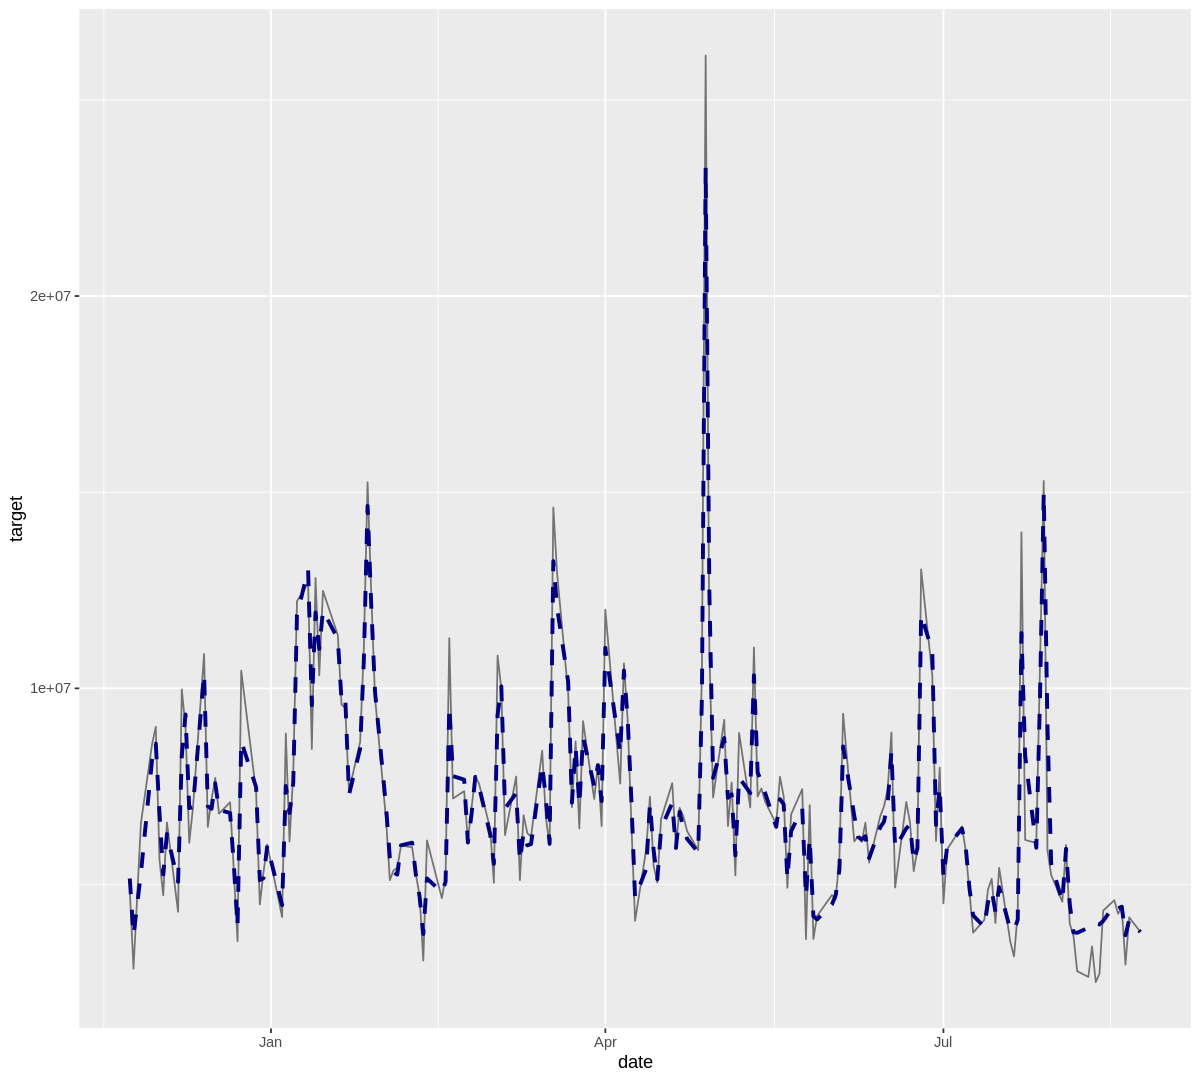

In [56]:
mod = xgb_final("FB", fb_xgb_params, train, test, df)

plot_df = df %>% filter(ticker == "FB") %>% select(date, target)
plot_df$pred = append(mod$trainpred, mod$testpred)
plot_df = plot_df %>% filter(date >= split)

print(paste0("Train: RMSE = ", round(mod$trainRMSE, 0), " MAPE = ", round(mod$trainMAPE * 100, 2), "%"))
print(paste0("Test: RMSE = ", round(mod$testRMSE, 0), " MAPE = ", round(mod$testMAPE * 100, 2), "%"))

ggplot(plot_df) +
  geom_line(aes(x = date, y = target), color = "gray45") +
  geom_line(aes(x = date, y = pred), color = "navy", linetype = "dashed", size = 1.1)

## **AAPL**

[1] "Train: RMSE = 3551590 MAPE = 4.62%"
[1] "Test: RMSE = 3868095 MAPE = 6.76%"


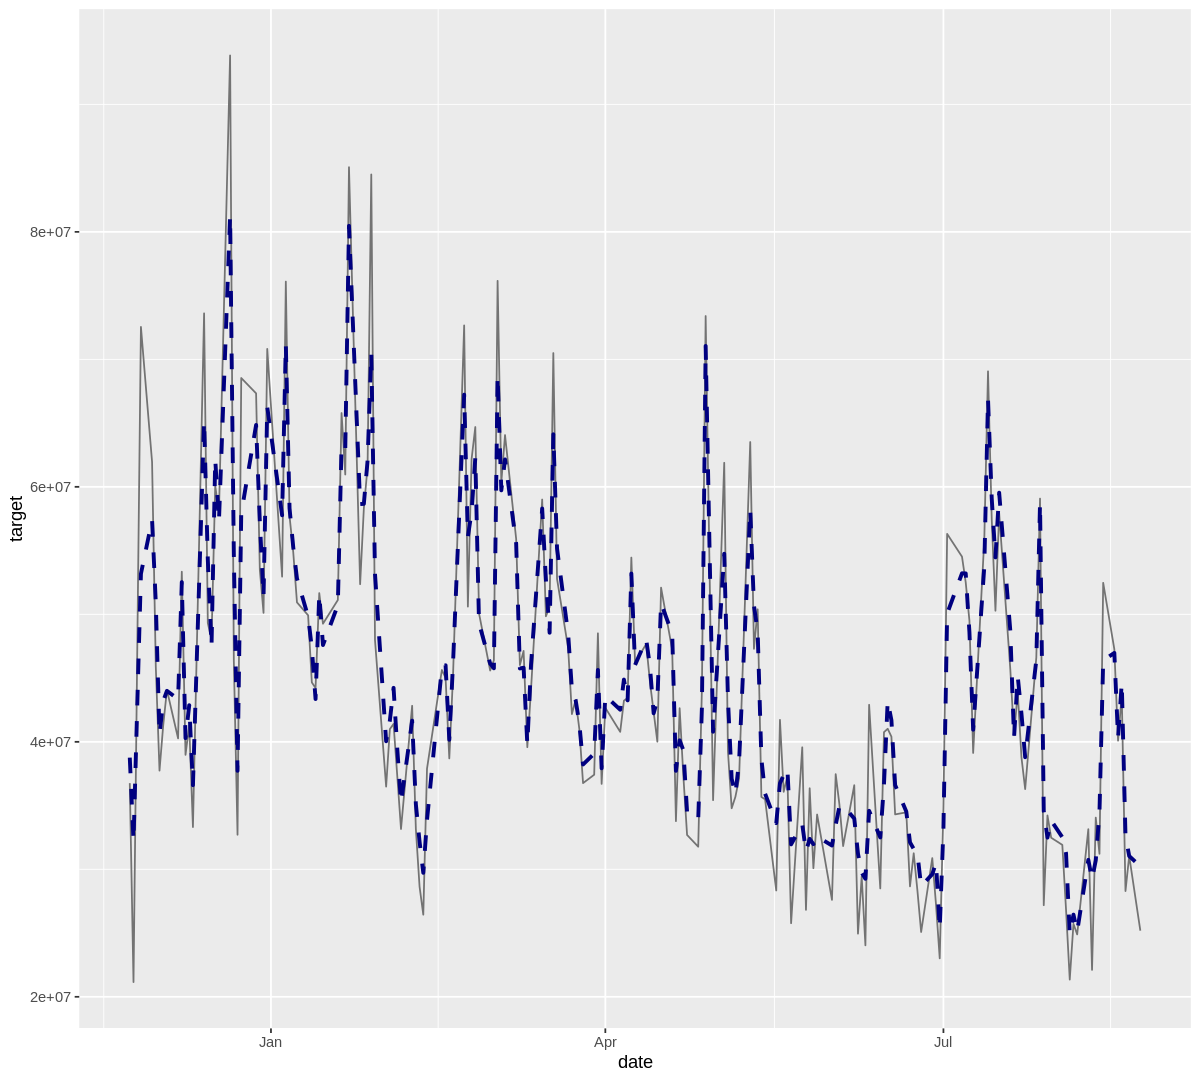

In [57]:
mod = xgb_final("AAPL", aapl_xgb_params, train, test, df)

plot_df = df %>% filter(ticker == "AAPL") %>% select(date, target)
plot_df$pred = append(mod$trainpred, mod$testpred)
plot_df = plot_df %>% filter(date >= split)

print(paste0("Train: RMSE = ", round(mod$trainRMSE, 0), " MAPE = ", round(mod$trainMAPE * 100, 2), "%"))
print(paste0("Test: RMSE = ", round(mod$testRMSE, 0), " MAPE = ", round(mod$testMAPE * 100, 2), "%"))

ggplot(plot_df) +
  geom_line(aes(x = date, y = target), color = "gray45") +
  geom_line(aes(x = date, y = pred), color = "navy", linetype = "dashed", size = 1.1)

## **AMZN**

[1] "Train: RMSE = 103740 MAPE = 4.08%"
[1] "Test: RMSE = 135338 MAPE = 8.71%"


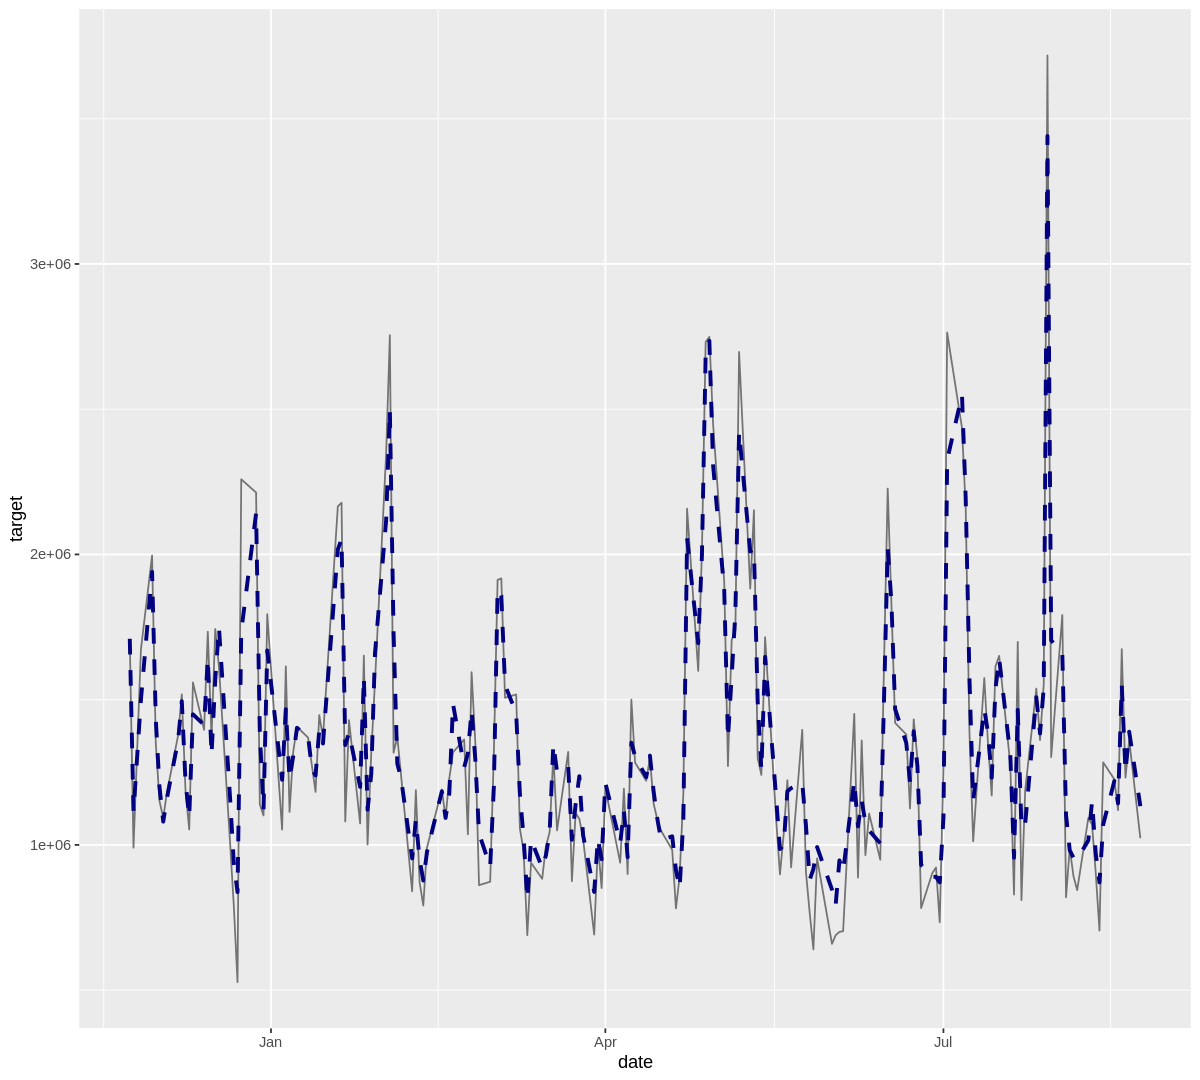

In [58]:
mod = xgb_final("AMZN", amzn_xgb_params, train, test, df)

plot_df = df %>% filter(ticker == "AMZN") %>% select(date, target)
plot_df$pred = append(mod$trainpred, mod$testpred)
plot_df = plot_df %>% filter(date >= split)

print(paste0("Train: RMSE = ", round(mod$trainRMSE, 0), " MAPE = ", round(mod$trainMAPE * 100, 2), "%"))
print(paste0("Test: RMSE = ", round(mod$testRMSE, 0), " MAPE = ", round(mod$testMAPE * 100, 2), "%"))

ggplot(plot_df) +
  geom_line(aes(x = date, y = target), color = "gray45") +
  geom_line(aes(x = date, y = pred), color = "navy", linetype = "dashed", size = 1.1)

## **NFLX**

[1] "Train: RMSE = 271411 MAPE = 5.15%"
[1] "Test: RMSE = 774473 MAPE = 59.04%"


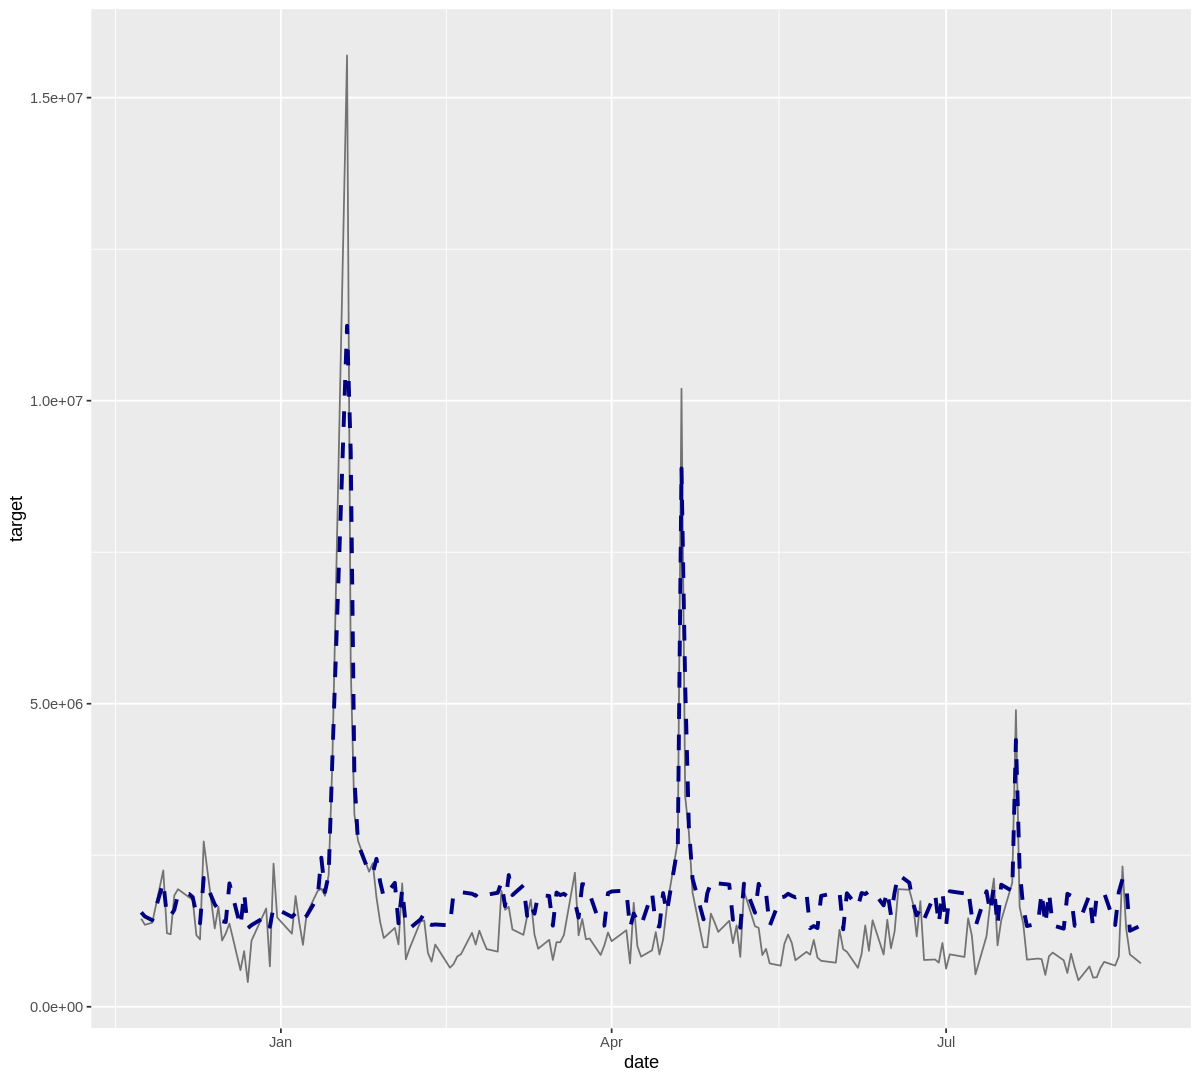

In [59]:
mod = xgb_final("NFLX", nflx_xgb_params, train, test, df)

plot_df = df %>% filter(ticker == "NFLX") %>% select(date, target)
plot_df$pred = append(mod$trainpred, mod$testpred)
plot_df = plot_df %>% filter(date >= split)

print(paste0("Train: RMSE = ", round(mod$trainRMSE, 0), " MAPE = ", round(mod$trainMAPE * 100, 2), "%"))
print(paste0("Test: RMSE = ", round(mod$testRMSE, 0), " MAPE = ", round(mod$testMAPE * 100, 2), "%"))

ggplot(plot_df) +
  geom_line(aes(x = date, y = target), color = "gray45") +
  geom_line(aes(x = date, y = pred), color = "navy", linetype = "dashed", size = 1.1)

## **GOOGL**

[1] "Train: RMSE = 31348 MAPE = 3.57%"
[1] "Test: RMSE = 80326 MAPE = 7.55%"


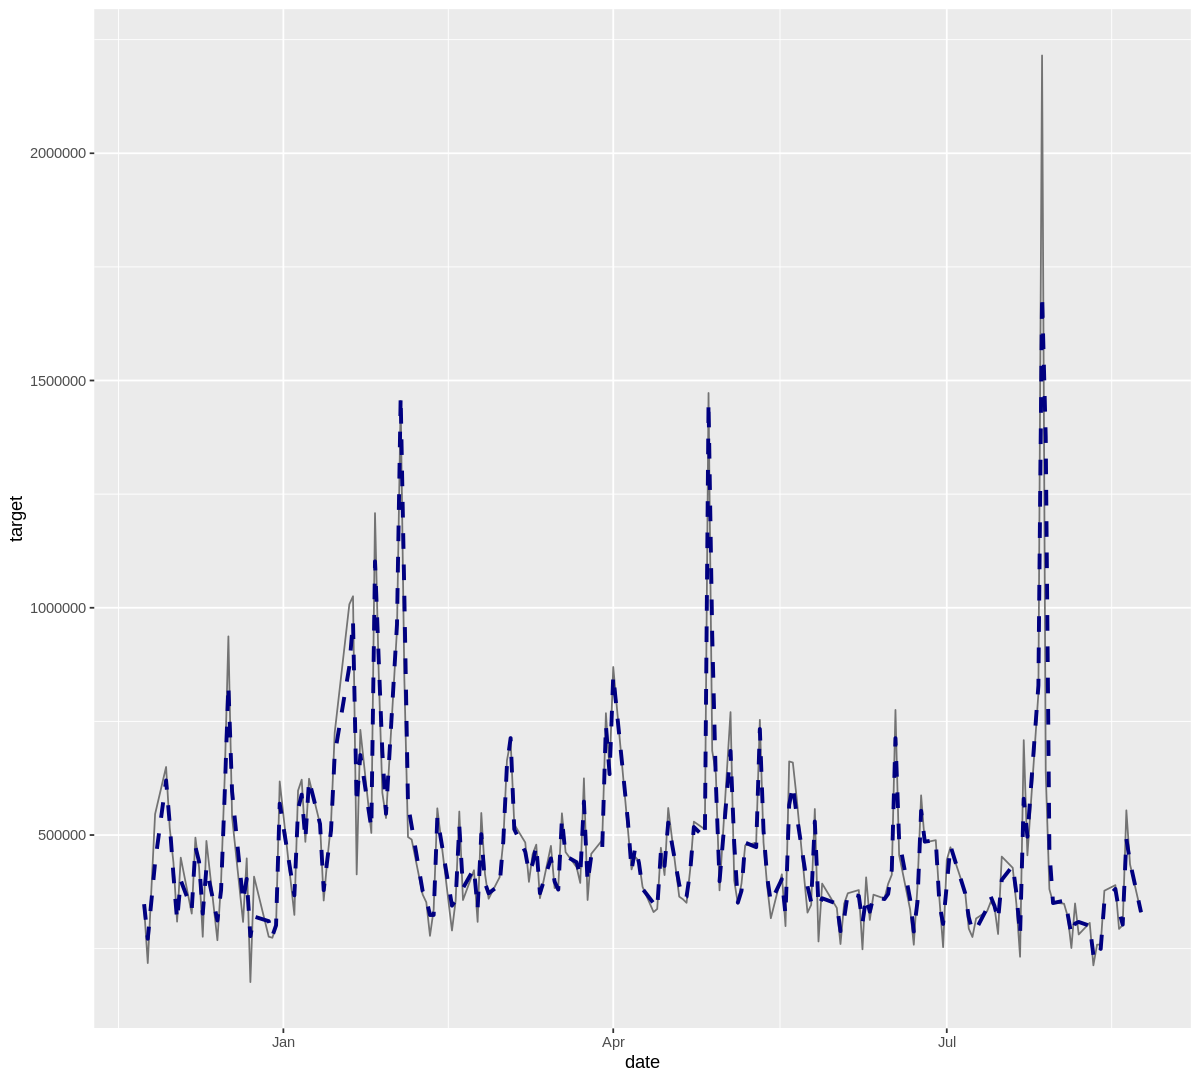

In [60]:
mod = xgb_final("GOOGL", googl_xgb_params, train, test, df)

plot_df = df %>% filter(ticker == "GOOGL") %>% select(date, target)
plot_df$pred = append(mod$trainpred, mod$testpred)
plot_df = plot_df %>% filter(date >= split)

print(paste0("Train: RMSE = ", round(mod$trainRMSE, 0), " MAPE = ", round(mod$trainMAPE * 100, 2), "%"))
print(paste0("Test: RMSE = ", round(mod$testRMSE, 0), " MAPE = ", round(mod$testMAPE * 100, 2), "%"))

ggplot(plot_df) +
  geom_line(aes(x = date, y = target), color = "gray45") +
  geom_line(aes(x = date, y = pred), color = "navy", linetype = "dashed", size = 1.1)